In [11]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

# Using Seurat for scRNASeq Analyses in GenePattern

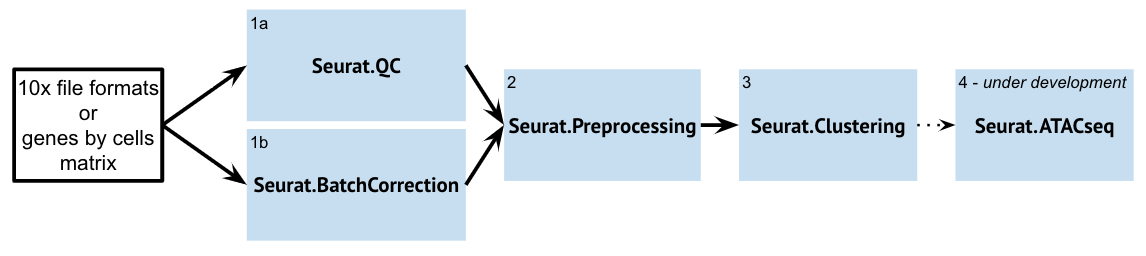

The steps below encompass the standard pre-processing workflow of scRNA-seq data in Seurat. We have split it in 4 sequential steps corresponding to:  
1. Data loading and visualization of QC metrics.
2. Data filtering, normalization, scaling, and dimensionality reduction.
3. Clustering.
4. Visualization of marker expression

# Input Data

### Formats

The Seurat Suite can take in data formatted in two different ways:
1. **A Loom file generated by the Human Cell Atlas project**

    For more information visit [the Human Cell Atlas Data Portal](https://data.humancellatlas.org/)
<br>
2. **10x Genomics (e.g., the outputs of CellRanger)**

    Note that this is a compressed folder which contains three files:
    - **matrix.mtx**: Triples of gene ID index, cell barcode index, and UMI count.
    - **barcodes.tsv**: The barcodes referenced by the indices in the **matrix.mtx** file.
    - **features.tsv**: All the annotated genes, one per row. Referenced by the indices in the **matrix.mtx** file. This file is sometimes named **genes.tsv**  

### Sample data

- If you'd like some sample data you can use the public dataset of **Peripheral Blood Mononuclear Cells (PBMCs)**, freely available from **10X Genomics**. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500 and ran through the Cell Ranger pipeline. the original files can be found [here](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

- Alternatively, you can download the Loom file containing a dataset with **Single cell RNA sequencing of multiple myeloma II** [from the Human Cell Atlas](https://data.humancellatlas.org/explore/projects/0c3b7785-f74d-4091-8616-a68757e4c2a8/m/project-matrices) this is 

# 1. Data loading and visualization of QC metrics

### QC metrics

Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics [commonly used](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/) by the community include
- The number of unique genes detected in each cell
    - Low-quality cells or empty droplets will often have very few genes
    - Cell doublets or multiplets may exhibit an aberrantly high gene count
- Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
- The percentage of reads that map to the mitochondrial genome
    - Low-quality/dying cells often exhibit extensive mitochondrial contamination
    - We calculate mitochondrial QC metrics with the `PercentageFeatureSet` function, which calculates the percentage of counts originating from a set of features
    - We use the set of all genes starting with `MT-` as a set of mitochondrial genes

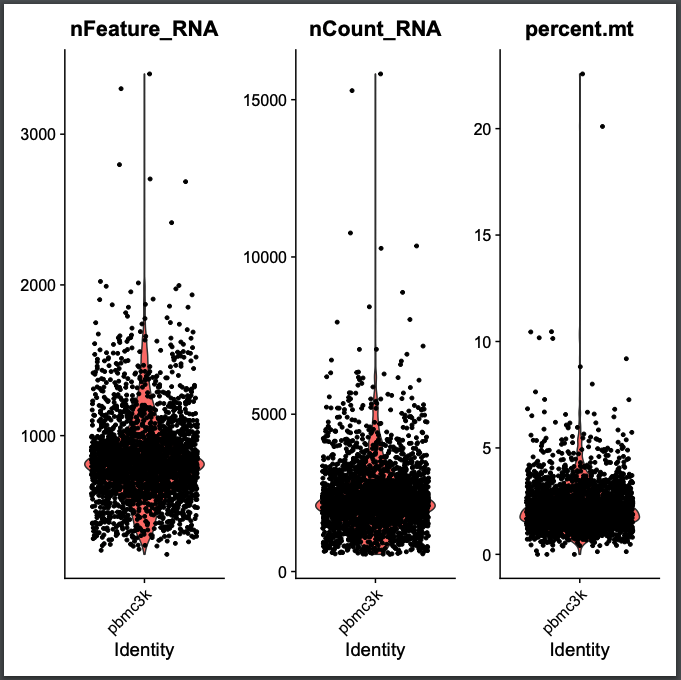

### What the GenePattern module looks like

In [20]:
seurat_qc_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00416')
seurat_qc_job_spec = seurat_qc_task.make_job_spec()
seurat_qc_job_spec.set_parameter("tenx_data_dir", "")
seurat_qc_job_spec.set_parameter("column_name", "percent.mt")
seurat_qc_job_spec.set_parameter("pattern", "MT-")
seurat_qc_job_spec.set_parameter("file_name", "seurat_qcd_dataset")
seurat_qc_job_spec.set_parameter("first_feature", "nFeature_RNA")
seurat_qc_job_spec.set_parameter("second_feature", "nCount_RNA")
seurat_qc_job_spec.set_parameter("third_feature", "percent.mt")
seurat_qc_job_spec.set_parameter("job.memory", "2 Gb")
seurat_qc_job_spec.set_parameter("job.queue", "gp-cloud-default")
seurat_qc_job_spec.set_parameter("job.cpuCount", "1")
seurat_qc_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(seurat_qc_task)

GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00416')

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>  
    
- for the `PDF to display*` parameter, choose the PDF output from `Seurat.QC`
- Click <b>Run</b>
</div>

In [15]:
import os
import requests
import genepattern
from IPython.display import IFrame
@genepattern.build_ui(name="Display PDF", parameters={
    "image": {
        "name": "PDF to display:",
        "description": "PDF file (typically named Rplots.pdf) from the Seurat.QC module",
        "type": "file",
        "kinds": ["pdf"]
    },
    "height":{"default":850, "hide":True},
    "width":{"default":850, "hide":True},
    "output_var": {
        "default":"output_var",
        "hide": True
    }
})
def displayPdf(image, height, width):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), image)
    basename=os.path.basename(image)
    resp = requests.get(image, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'})
    job_widget.status = 'Writing pdf file to your workspace. This may take a minute.'
    with open(basename, "wb") as f:
        f.write(resp.content)
    
    job_widget.status = basename+' successfully written to the same folder as this notebook!'
    display(IFrame(basename,width, height))
    return

UIBuilder(function_import='nbtools.tool(id="Display PDF", origin="Notebook").function_or_method', name='Displa…

# 2. Data filtering, normalization, scaling, and dimensionality reduction (preprocessing)

### Filtering cells that don't meet QC

Here we select which cells and genes we will filter out of our dataset based on the plots above.

### Normalizing and scaling the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method "LogNormalize" that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in `pbmc[["RNA"]]@data`. The methods we will use in this notebook all assume log-normalized data, other methods may not make that assumption and other normalization methods can be considered.

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). [The literature](https://www.nature.com/articles/nmeth.2645) suggests that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

Seurat's variable feature selection is described in detail [here](https://www.biorxiv.org/content/early/2018/11/02/460147.full.pdf), and improves on previous methods by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the `FindVariableFeatures` function. By default, it returns 2,000 features per dataset. These will be used in downstream analyses such as PCA.

Next, we apply a linear transformation (*scaling*) that is a standard preprocessing step prior to dimensional reduction techniques like PCA. The `ScaleData` function:
- Shifts the expression of each gene so that the mean expression across cells is 0
- Scales the expression of each gene so that the variance across cells is 1
    - This step gives equal weight in downstream analyses (which may apply weights based on variance), so that highly-expressed genes do not dominate
- The results of this are stored in `pbmc[[\"RNA\"]]@scale.data`

### Dimensionality reduction (PCA)

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using the features argument if the user wishes to choose a different subset.

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimReduction, DimPlot, and DimHeatmap

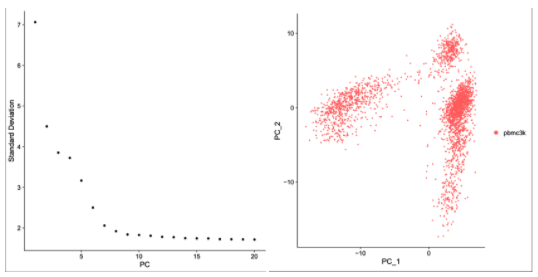

#### Determine the 'dimensionality' of the dataset  

To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a 'metafeature' that combines information across a correlated feature set. The top principal components therefore represent a robust compression of the dataset. However, how many components should we choose to include? 10? 20? 100?

To do this we will use a heuristic method which generates an 'Elbow plot': a ranking of principal components based on the percentage of variance explained by each one (`ElbowPlot` function). In this example, we can observe an 'elbow' around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

In particular `DimHeatMap` allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide how many PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting `cells` to a number plots the 'extreme' cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

### Run the module

In [13]:
seurat_preprocessing_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00415')
seurat_preprocessing_job_spec = seurat_preprocessing_task.make_job_spec()
seurat_preprocessing_job_spec.set_parameter("input_rds", "")
seurat_preprocessing_job_spec.set_parameter("file_name", "seurat_preprocessed_dataset")
seurat_preprocessing_job_spec.set_parameter("min_n_features", "200")
seurat_preprocessing_job_spec.set_parameter("max_n_features", "2500")
seurat_preprocessing_job_spec.set_parameter("max_percent_mitochondrial", "7.5")
seurat_preprocessing_job_spec.set_parameter("norm_method", "LogNormalize")
seurat_preprocessing_job_spec.set_parameter("scale_factor", "10000")
seurat_preprocessing_job_spec.set_parameter("feat_sel_method", "vst")
seurat_preprocessing_job_spec.set_parameter("num_features", "2000")
seurat_preprocessing_job_spec.set_parameter("num_to_label", "10")
seurat_preprocessing_job_spec.set_parameter("vdl_num_dims", "2")
seurat_preprocessing_job_spec.set_parameter("vdhm_num_dims", "15")
seurat_preprocessing_job_spec.set_parameter("cells", "500")
seurat_preprocessing_job_spec.set_parameter("job.memory", "2 Gb")
seurat_preprocessing_job_spec.set_parameter("job.queue", "gp-cloud-default")
seurat_preprocessing_job_spec.set_parameter("job.cpuCount", "1")
seurat_preprocessing_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(seurat_preprocessing_task)

GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00415')

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>  
    
- for the `PDF to display*` parameter, choose the PDF output from `Seurat.Preprocessing`
- Click <b>Run</b>
</div>

In [16]:
@genepattern.build_ui(name="Display PDF", parameters={
    "image": {
        "name": "PDF to display:",
        "description": "PDF file (typically named Rplots.pdf) from the Seurat.Preprocessing module",
        "type": "file",
        "kinds": ["pdf"]
    },
    "height":{"default":750, "hide":True},
    "width":{"default":1000, "hide":True},
    "output_var": {
    "hide": True
    }
})
def displayPdf(image, height, width):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), image)
    basename=os.path.basename(image)
    resp = requests.get(image, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'})
    job_widget.status = 'Writing pdf file to your workspace. This may take a minute.'
    with open(basename, "wb") as f:
        f.write(resp.content)
    
    job_widget.status = basename+' successfully retrieved.'
    display(IFrame(basename,width, height))
    return

UIBuilder(function_import='nbtools.tool(id="Display PDF", origin="Notebook").function_or_method', name='Displa…

# 3. Cluster Cells


Following preprocessing, we will now *cluster*, or identify similar populations of cells within our dataset. This can be used to, for example, identify cells corresponding to specific cell types or separate healthy and diseased cells. Seurat uses a "graph-based" clustering approach, which relies on drawing connections between similar cells and separating them into similar groups, or "cliques".

The GenePattern Module below will use the GenePattern Cloud infrastructure to run Seurat clustering. You can upload the preprocessed `.rds` file we saved above and specify the **maximum dimension**, the number of principal components to use for clustering, and the **resolution** parameter, which affects the number of clusters detected. Higher resolution values will generally yield more clusters. When clustering new data, it is wise to experiment with a range of resolution values.

You can also specify the **reduction** method. This refers to the algorithm that will be used to further reduce the PCA data to two dimensions for the purpose of visualization. The single cell community is still considering the merits and drawbacks of various dimensionality reduction methods for visualization, such as UMAP[**2**] and tSNE[**3**], but consensus is currently forming around UMAP, and we recommend its use in this notebook.

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>
    
For the parameter named **input seurat rds file** click on the down arrow (<i class="fa fa-sort-down"></i>) and select `seurat_preprocessed_dataset.rds`
</div>

In [14]:
seuratclustering_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00408')
seuratclustering_job_spec = seuratclustering_task.make_job_spec()
seuratclustering_job_spec.set_parameter("input.seurat.rds.file", "")
seuratclustering_job_spec.set_parameter("output.filename", "<input.seurat.rds.file_basename>.clustered")
seuratclustering_job_spec.set_parameter("maximum_dimension", "15")
seuratclustering_job_spec.set_parameter("resolution", "0.5")
seuratclustering_job_spec.set_parameter("reduction", "umap")
seuratclustering_job_spec.set_parameter("nmarkers", "50")
seuratclustering_job_spec.set_parameter("job.memory", "2 Gb")
seuratclustering_job_spec.set_parameter("job.queue", "gp-cloud-default")
seuratclustering_job_spec.set_parameter("job.cpuCount", "1")
seuratclustering_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(seuratclustering_task)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00408')

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>  
    
- for the `PDF to display*` parameter, choose the PDF output from `Seurat.Clustering`
- Click <b>Run</b>
</div>

In [17]:
@genepattern.build_ui(name="Display PDF", parameters={
    "image": {
        "name": "PDF to display:",
        "description": "PDF file (typically named Rplots.pdf) from the Seurat.Preprocessing module",
        "type": "file",
        "kinds": ["pdf"]
    },
    "height":{"default":750, "hide":True},
    "width":{"default":1000, "hide":True},
    "output_var": {
    "hide": True
    }
})
def displayPdf(image, height, width):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), image)
    basename=os.path.basename(image)
    resp = requests.get(image, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'})
    job_widget.status = 'Writing pdf file to your workspace. This may take a minute.'
    with open(basename, "wb") as f:
        f.write(resp.content)
    
    job_widget.status = basename+' successfully retrieved.'
    display(IFrame(basename,width, height))
    return

UIBuilder(function_import='nbtools.tool(id="Display PDF", origin="Notebook").function_or_method', name='Displa…

# 4. Visualize Marker Expression

Here we Visualize marker expression as violin plots and on a UMap.

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>  
    
- For the parameter named **input file** click on the down arrow (<i class="fa fa-sort-down"></i>) and select the `.rds` created by `Seurat.Clustering`
- For the parameter named **genes** type the list of genes/markers you would like to visualize. If you write more than one, they have to be separated by a comma and a space. e.g., MS4A1, MYC, CD74
</div>

In [19]:
seurat_visualizemarkerexpression_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00421')
seurat_visualizemarkerexpression_job_spec = seurat_visualizemarkerexpression_task.make_job_spec()
seurat_visualizemarkerexpression_job_spec.set_parameter("input_file", "")
seurat_visualizemarkerexpression_job_spec.set_parameter("genes", "")
seurat_visualizemarkerexpression_job_spec.set_parameter("group_plots", "Horizontally")
seurat_visualizemarkerexpression_job_spec.set_parameter("output_file_name", "SeuratMarkers")
seurat_visualizemarkerexpression_job_spec.set_parameter("job.memory", "2 Gb")
seurat_visualizemarkerexpression_job_spec.set_parameter("job.walltime", "02:00:00")
seurat_visualizemarkerexpression_job_spec.set_parameter("job.cpuCount", "1")
genepattern.display(seurat_visualizemarkerexpression_task)


GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00421')

<div class="alert alert-info">
<p class="lead"> Instructions <i class="fa fa-info-circle"></i></p>  
    
- for the `PDF to display*` parameter, choose the PDF output from `Seurat.VisualizeMarkerExpression`
- Click <b>Run</b>
</div>

In [18]:
@genepattern.build_ui(name="Display PDF", parameters={
    "image": {
        "name": "PDF to display:",
        "description": "PDF file (typically named Rplots.pdf) from the Seurat.Preprocessing module",
        "type": "file",
        "kinds": ["pdf"]
    },
    "height":{"default":750, "hide":True},
    "width":{"default":1000, "hide":True},
    "output_var": {
    "hide": True
    }
})
def displayPdf(image, height, width):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), image)
    basename=os.path.basename(image)
    resp = requests.get(image, headers={
        'Authorization': f.server_data.authorization_header(), 
        'User-Agent': 'GenePatternRest'})
    job_widget.status = 'Writing pdf file to your workspace. This may take a minute.'
    with open(basename, "wb") as f:
        f.write(resp.content)
    
    job_widget.status = basename+' successfully retrieved.'
    display(IFrame(basename,width, height))
    return

UIBuilder(function_import='nbtools.tool(id="Display PDF", origin="Notebook").function_or_method', name='Displa…

# References

1. Satija, R., Farrell, J., Gennert, D. et al. Spatial reconstruction of single-cell gene expression data. Nat Biotechnol 33, 495–502 (2015). https://doi.org/10.1038/nbt.3192

2. Hao, Yuhan, Stephanie Hao, Erica Andersen-Nissen, William M. Mauck III, Shiwei Zheng, Andrew Butler, Maddie J. Lee, et al. “Integrated Analysis of Multimodal Single-Cell Data.” Cell 184, no. 13 (June 2021): 3573-3587.e29. https://doi.org/10.1016/j.cell.2021.04.048.

